# PyMC3 minimal working example and diagnostics
- Python package for Bayesian statistical modeling and Probabilistic Programming;
- Focus on advanced Markov chain Monte Carlo (MCMC) and variational inference (VI) algorithms;
- Great flexibility and direct interaction with the model.

## Useful links
- Get started with [PyMC3](https://docs.pymc.io/notebooks/getting_started)
- PyMC3 parameters [setting](https://docs.pymc.io/api/inference.html)
- PyMC3 [Github](https://github.com/pymc-devs/pymc3)
- PyMC3 [paper](https://peerj.com/articles/cs-55/)

## import X and y, first 3 genes in block 313
- X: $23,856$ by $3$, the 3rd gene has non-zero effect 1.077. The 2nd and 3rd genes are in complete LD. Fisher test p value 2.732e-12.
- y: $23,856$

In [2]:
import os, pickle
import numpy as np, pandas as pd
cwd = os.path.expanduser("~/GIT/cnv-gene-mapping/data/deletion_simu_30_shape0.777_scale0.843")
X = pd.read_csv(f'{cwd}/block_1151_1159/deletion.genes.block30.for_simu.sample.combined.genes.block_1151_1159.gz', compression = "gzip", sep = "\t", header = None, dtype = float)
X = X.iloc[:, :3]
X = X.astype(int)
y = np.loadtxt(f'{cwd}/deletion.genes.block30.for_simu.sample.combined.y.gz', dtype=int)

In [3]:
X.to_csv("~/Downloads/block313.gz", compression = "gzip", sep = "\t", header = False, index = False)

## Spike and Slab model
Spike-and-Slab Model [link](https://www.kaggle.com/melondonkey/bayesian-spike-and-slab-in-pymc3)

In [4]:
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

`pi_varbvs`, `mu_varbvs` and `si_varbvs` are from whole genome varbvs.

$\beta_k = (1-\pi_k)\delta_0 + \pi_k N(\mu, \sigma)$
- `pi_varbvs`: $\pi_k$ in spike-and-slab prior
- `mu_varbvs`: $\mu$ in spike-and-slab prior for β$_k$
- `si_varbvs`: $\sigma$ in spike-and-slab prior for β$_k$

In [5]:
pi_varbvs = 0.051366009925488
mu_varbvs = 0.783230896500752
si_varbvs = 0.816999481742865

### Parameters
- iteration: The number of repetition;
- tune_prop: The proportion of tuning to iteration; if iteration = 10000 and tune_prop = 0.25, then tuning number is 2500. Tune means we discard the first n tuning samples; Default is 500 tuning samples.
- n_chain: The number of chains.
- n_core: The number of cores used for sampling.
- target_accept: Adapt the step size such that the average acceptance probability across the trajectories are close to target_accept. Default is 0.8. Higher values for target_accept lead to smaller step sizes.

In [6]:
iteration = 10000
tune_prop = 0.25
seed = 1
n_chain = 10
n_core = 8
target_accept = 0.98

### Model
- Original:

$\beta \sim N(\mu,\sigma)$\
$\alpha \sim U(\text{lower, upper})$, where upper = log$\frac{\text{case prop}}{1-\text{case prop}}$, lower = log$\frac{\text{prevalence}}{1-\text{prevalence}}$

- Reparameterization: If we can't easily make the sampler step-size adjust to the region of space, we can adjust the region of space to make it simpler for the sampler. It can be done with a reparameterization trick. We call this the non-centered version.

$\beta_{\text{offset}} \sim N(0,1)$ \
$\beta = \mu + \sigma * \beta_{\text{offset}}$ \
$\alpha_{\text{offset}} \sim U(-1,1)$ \
$\alpha = \text{lower} + (\alpha_{\text{offset}}+1)/2*(\text{upper}-\text{lower})$

In [7]:
def get_model(y, X, pi0 = pi_varbvs, mu = mu_varbvs, sigma = si_varbvs, prevalence = 0.05, transform = False):
    case_prop = sum(y) / y.shape[0]
    invlogit = lambda x: 1/(1 + tt.exp(-x))
    upper = np.log(case_prop / (1-case_prop))
    lower = np.log(prevalence / (1-prevalence))
    model = pm.Model()
    with model:
        xi = pm.Bernoulli('xi', pi0, shape = X.shape[1]) # inclusion probability for each variable
        # Transformed, non-centered version:
        if transform:
            # reparameterization to non-centered hierarchical model helps with sampling at hierarchical funnel
            beta_offset = pm.Normal('beta_offset', mu = 0, sd = 1, shape = X.shape[1]) # Prior for the non-zero coefficients
            alpha_offset = pm.distributions.continuous.Uniform("alpha_offset", lower = -1, upper = 1)
            beta = pm.Deterministic("beta", mu + beta_offset * sigma)
            alpha = pm.Deterministic("alpha", lower + (alpha_offset+1)/2*(upper - lower))
        # original
        else:
            beta = pm.Normal('beta', mu = mu, sd = sigma, shape = X.shape[1])
            alpha = pm.distributions.continuous.Uniform("alpha", lower = lower, upper = upper)
        p = pm.math.dot(X, xi * beta) # Deterministic function to map the stochastics to the output
        y_obs = pm.Bernoulli('y_obs', invlogit(p + alpha), observed = y)  # logistic regression
    return model

In [8]:
model = get_model(y,X)

In [9]:
model

## Sampling trace1: iteration = 10000, chain = 10

In [11]:
with model:
    trace1 = pm.sample(draws = iteration, random_seed = seed, cores = min(n_core, n_chain), progressbar = True, chains = n_chain, tune = int(tune_prop*iteration), nuts = {"target_accept": target_accept})

Multiprocess sampling (10 chains in 8 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [alpha, beta]
Sampling 10 chains, 0 divergences: 100%|██████████| 125000/125000 [2:36:07<00:00, 13.34draws/s] 
The acceptance probability does not match the target. It is 0.9384021436599737, but should be close to 0.98. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9521503513399436, but should be close to 0.98. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9484911785942997, but should be close to 0.98. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9216380493467464, but should be close to 0.98. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [12]:
pickle.dump(trace1, open(f"{cwd}/Block313_3genes_1effect.pkl", "wb"))

### Results

In [14]:
res1 = pd.DataFrame({'inclusion_probability': np.apply_along_axis(np.mean, 0, trace1['xi']),
              'beta': np.apply_along_axis(np.mean, 0, np.multiply(trace1["beta"], trace1["xi"])), # posterior mean of beta
              'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace1['xi'] * trace1['beta']) / np.apply_along_axis(np.sum, 0, trace1['xi'])
             })

In [15]:
res1

,inclusion_probability,beta,beta_given_inclusion
0,0.01478,-0.001423,-0.096281
1,0.48955,0.553709,1.131057
2,0.53084,0.603909,1.137648


## MCMC Trace Diagnostics
- PyMC3 MCMC Trace [Diagnostics](https://eigenfoo.xyz/bayesian-modelling-cookbook/#mcmc-trace-diagnostics)
- PyMC3 diagnosing Biased Inference with [Divergences](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html)
- reference [link2](https://calogica.com/pymc3/python/2019/12/08/nfl-4thdown-attempts.html)

$\hat{R}$ (last column of the table): the Gelman–Rubin statistic; the potential scale reduction factor (PSRF); can be interpreted as a convergence diagnostic. It measures how similar the chains are. Ideally it should be close to 1.

PyMC3 includes a handy summary function that provides us with a few key estimates per variable. Aside from mean and the range covered in the hpd (highest posterior density) columns, we also want to make sure `r_hat` is ~1, while the effective sample sizes (ess) per variable are high enough to explore the posterior tails. A low number of effective samples is usually an indication of strong autocorrelation in the chain.

Effective sample sizes for $\beta_6$ and $\beta_7$ are small and their `r_hat`'s are slightly greater than 1.

In [16]:
pm.summary(trace1).round(4)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
xi[0],0.015,0.121,0.000,0.000,0.001,0.000,56287.0,56287.0,56287.0,56287.0,1.00
xi[1],0.490,0.500,0.000,1.000,0.025,0.018,393.0,393.0,393.0,393.0,1.03
xi[2],0.531,0.499,0.000,1.000,0.025,0.018,391.0,391.0,391.0,391.0,1.03
beta[0],0.768,0.822,-0.751,2.324,0.003,0.003,63978.0,53756.0,63997.0,60420.0,1.00
beta[1],0.951,0.636,-0.525,2.063,0.009,0.006,5429.0,5429.0,7905.0,8210.0,1.01
beta[2],0.973,0.607,-0.473,2.023,0.009,0.006,4391.0,4391.0,6410.0,7177.0,1.01
alpha,-0.014,0.009,-0.030,-0.000,0.000,0.000,55348.0,55348.0,39676.0,27405.0,1.00


## Sampling trace2: iteration = 20000, chain = 2

In [1]:
iteration2 = 20000
tune_prop2 = 0.25
n_chain2 = 2
n_core2 = 2

In [10]:
with model:
    trace2 = pm.sample(draws = iteration2, random_seed = seed, cores = min(n_core2, n_chain2), progressbar = True, chains = n_chain2, tune = int(tune_prop2*iteration2), nuts = {"target_accept": target_accept})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [alpha, beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 50000/50000 [1:06:44<00:00, 12.49draws/s]
The acceptance probability does not match the target. It is 0.9515713837101777, but should be close to 0.98. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
pickle.dump(trace2, open(f"{cwd}/Block313_3genes_1effect_50000_2.pkl", "wb"))

In [12]:
res2 = pd.DataFrame({'inclusion_probability': np.apply_along_axis(np.mean, 0, trace2['xi']),
              'beta': np.apply_along_axis(np.mean, 0, np.multiply(trace2["beta"], trace2["xi"])), # posterior mean of beta
              'beta_given_inclusion': np.apply_along_axis(np.sum, 0, trace2['xi'] * trace2['beta']) / np.apply_along_axis(np.sum, 0, trace2['xi'])
             })

In [13]:
res2

,inclusion_probability,beta,beta_given_inclusion
0,0.014400,-0.001217,-0.084500
1,0.472125,0.535198,1.133594
2,0.548125,0.622371,1.135454


In [25]:
X.corr()

,0,1,2
0,1.000000,0.840862,0.840862
1,0.840862,1.000000,1.000000
2,0.840862,1.000000,1.000000


### Check the traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ac1254350>,
      dtype=object)

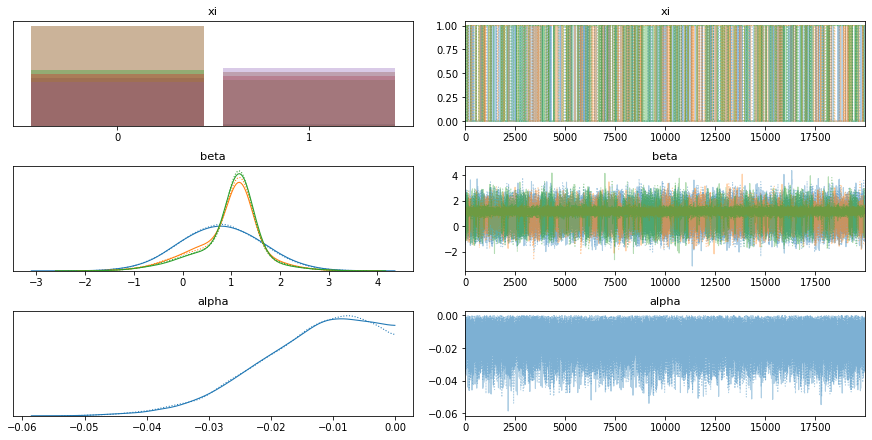

In [14]:
pm.traceplot(trace2)

### Check if posteriors look reasonable

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ac9b415d0>,
      dtype=object)

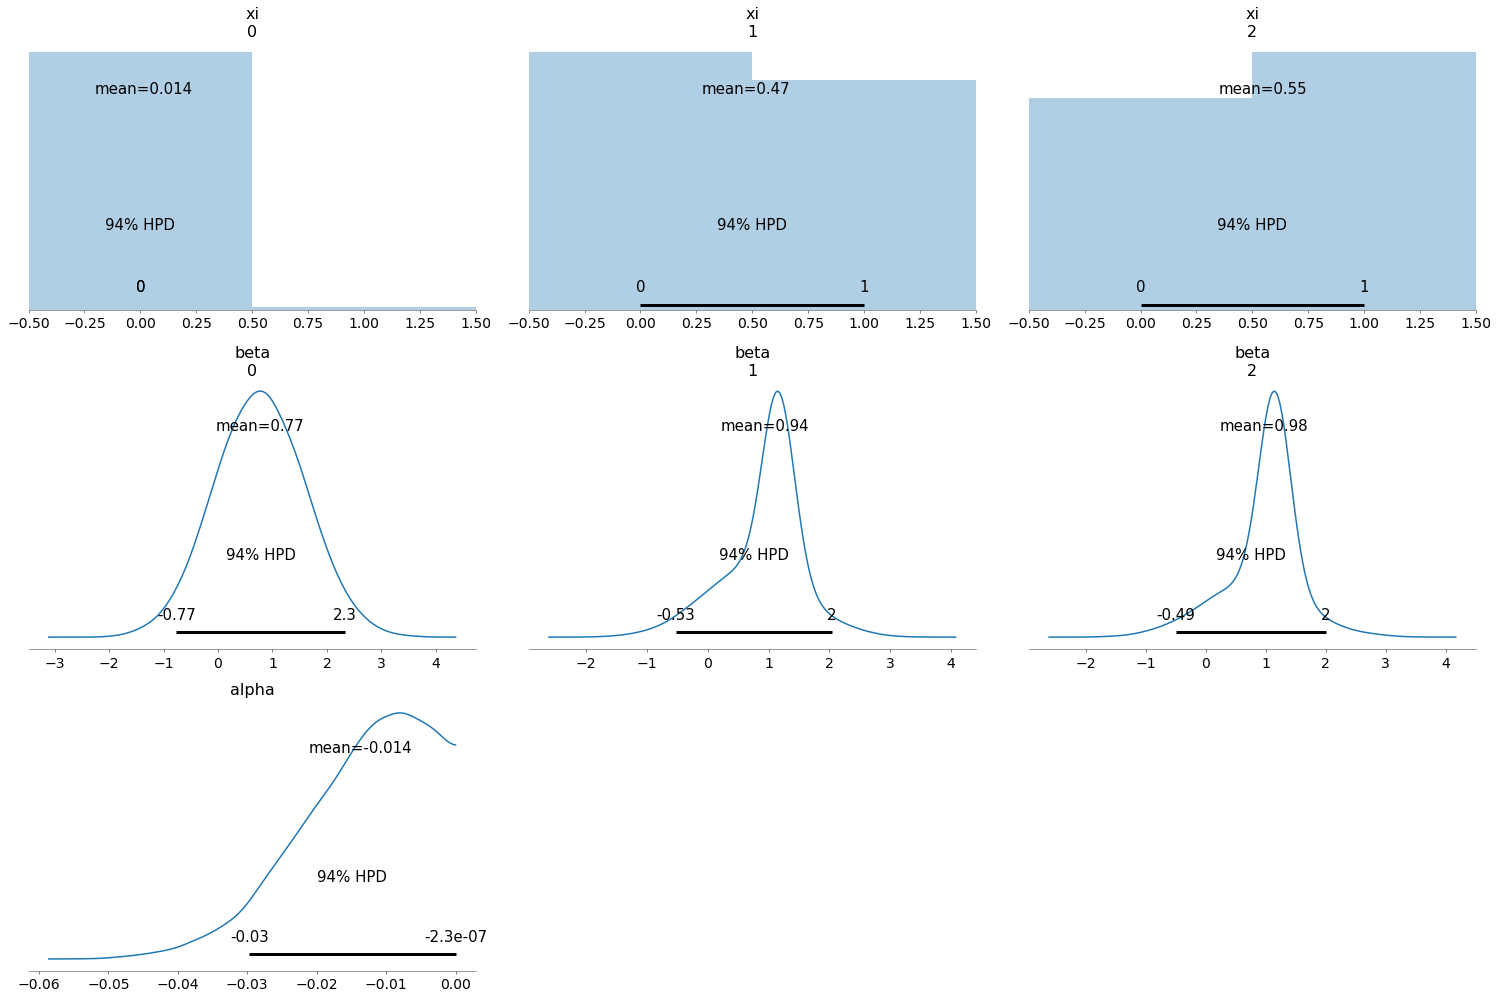

In [15]:
pm.plot_posterior(trace2)

In [22]:
def report_trace(trace, n=0):
    beta = trace['beta'][:,n]
    mbeta = [np.mean(beta[:i]) for i in np.arange(1,len(beta))]
    plt.figure(figsize=(15, 4))
    plt.plot(mbeta, lw=2.5)
    plt.ylim(min(mbeta)*0.8, max(mbeta)*1.1)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of beta')
    plt.title('MCMC estimation of beta')
    plt.show()
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

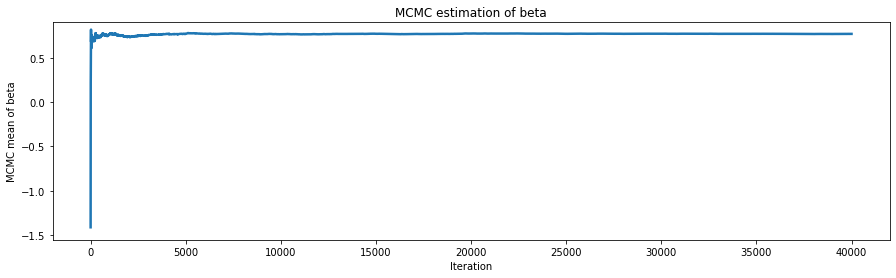

Number of Divergent 0
Percentage of Divergent 0.0


In [23]:
report_trace(trace2, n=0)

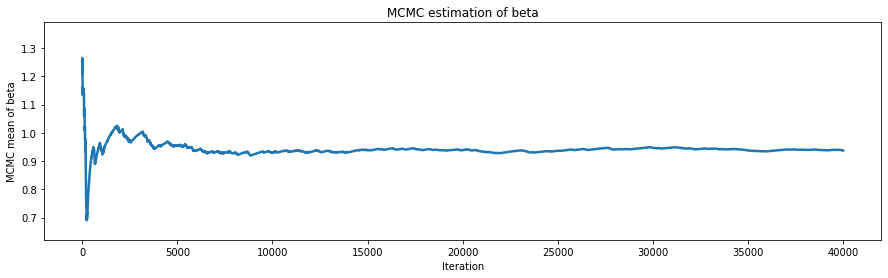

Number of Divergent 0
Percentage of Divergent 0.0


In [18]:
report_trace(trace2, n=1)

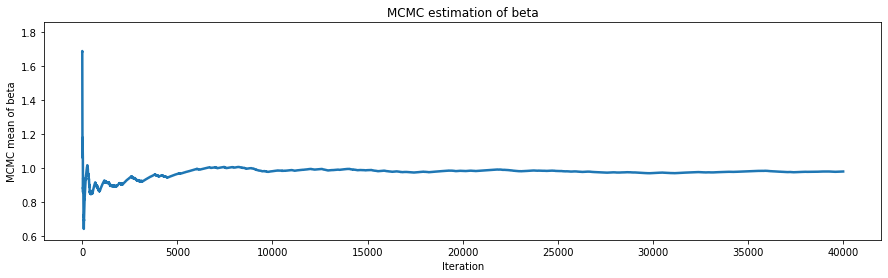

Number of Divergent 0
Percentage of Divergent 0.0


In [19]:
report_trace(trace2, n=2)